Import necessory modules

In [95]:
import numpy as np
import pandas as pd
import os
import keras
import cv2
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras import regularizers
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns

Following code snippit is for colab users. Ignore it if you are not working on colab


In [96]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [97]:
train_dir = "/content/drive/MyDrive/newlocal"

`load_unique()` loads all the lables 

In [98]:
def load_unique():
    size_img = 256,256 
    images_for_plot = []
    labels_for_plot = []
    for folder in os.listdir(train_dir):
        for file in os.listdir(train_dir + '/' + folder):
            filepath = train_dir + '/' + folder + '/' + file
            image = cv2.imread(filepath)
            final_img = cv2.resize(image, size_img)
            final_img = cv2.cvtColor(final_img, cv2.COLOR_BGR2RGB)
            images_for_plot.append(final_img)
            labels_for_plot.append(folder)
            break
    return images_for_plot, labels_for_plot

images_for_plot, labels_for_plot = load_unique()
print("unique_labels = ", labels_for_plot)

unique_labels =  ['acne', 'fungal', 'psoriasis', 'ringworm']


`plot_images()` is defined to visualise the images

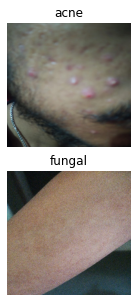

In [99]:
fig = plt.figure(figsize = (5,5))
def plot_images(fig, image, label, row, col, index):
    fig.add_subplot(row, col, index)
    plt.axis('off')
    plt.imshow(image)
    plt.title(label)
    return

image_index = 0
row = 2
col = 1
for i in range(0,(row*col)):
    plot_images(fig, images_for_plot[image_index], labels_for_plot[image_index], row, col, i+1)
    image_index = image_index + 1
plt.show()

`load_data()` loads the images and labels and also split it for testing purpose

In [100]:
labels_dict = {'acne':0,'psoriasis':1,'ringworm':2,'fungal':3}

def load_data():
    try:
        images = []
        labels = []
        size = 256,256
        print("LOADING DATA FROM : ",end = "")
        #print( os.listdir(train_dir+"/fungal"))
        for folder in os.listdir(train_dir):
            print(folder, end = ' | ')
            for image in os.listdir(train_dir + "/" + folder):
              try:
                temp_img = cv2.imread(train_dir + '/' + folder + '/' + image)
                temp_img = cv2.resize(temp_img, size)
                images.append(temp_img)
                labels.append(labels_dict[folder])
              except:
                pass
        images = np.array(images)
        #images = images.astype('float32')/255.0

        templabels = labels

        labels = to_categorical(labels)

        X_train, X_test, Y_train, Y_test = train_test_split(images, labels, test_size = 0.000000001)
        
        #print()
        #print('Loaded', len(X_train),'images for training,','Train data shape =',X_train.shape)
        #print('Loaded', len(X_test),'images for testing','Test data shape =',X_test.shape)
        return X_train, Y_train, X_test, Y_test, templabels
        
    except:
        pass
    

In [101]:
X_train, Y_train,  X_test, Y_test, labels = load_data()

LOADING DATA FROM : acne | fungal | psoriasis | ringworm | 

Following code snippit normalise the image

In [102]:
#x_train = np.asarray(X_train.tolist())
#x_test = np.asarray(X_test.tolist())

x_train_mean = np.mean(X_train)
x_train_std = np.std(X_train)

x_test_mean = np.mean(X_test)
x_test_std = np.std(X_test)

x_train = (X_train - x_train_mean)/x_train_std
x_test = (X_test - x_test_mean)/x_test_std

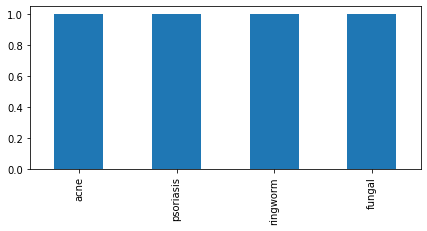

In [103]:
labelsdf = pd.DataFrame()
labelsdf["labels"] = labels_dict
labelsdf["labels"].value_counts().plot(kind = "bar", figsize = (7,3))

Following code snippit contains the CNN architecture

In [104]:
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, LeakyReLU, Activation
from keras.layers.advanced_activations import LeakyReLU

def create_model():
  input_shape = (256, 256, 3)
  num_classes = 4
  
 

  model = Sequential()
  model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
  model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
  model.add(MaxPool2D(pool_size = (2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
  model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation='softmax'))



  model.compile(loss='binary_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])
  print("MODEL CREATED")
  model.summary()
  return model

In [109]:

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

from keras.callbacks import EarlyStopping
def fit_model():
  #callbacks = [EarlyStopping(monitor='val_acc', patience=4, verbose=1, mode='max'), checkpoint]
  model_hist = model.fit(datagen.flow(x_train,Y_train, batch_size=32), epochs =12,  validation_data = (x_test, Y_test), verbose=1)
  return model_hist

In [110]:
from keras.callbacks import EarlyStopping
def fit_model():
    #callbacks = [EarlyStopping(monitor='val_acc', patience=4, verbose=1, mode='max')]
    model_hist = model.fit(x_train, Y_train, batch_size = 32, epochs = 12, validation_split = 0.1, verbose=1)
    return model_hist

In [111]:
model = create_model()
curr_model_hist = fit_model()

MODEL CREATED
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 256, 256, 32)      896       
                                                                 
 conv2d_41 (Conv2D)          (None, 256, 256, 32)      9248      
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 128, 128, 32)     0         
 g2D)                                                            
                                                                 
 dropout_30 (Dropout)        (None, 128, 128, 32)      0         
                                                                 
 conv2d_42 (Conv2D)          (None, 128, 128, 64)      18496     
                                                                 
 conv2d_43 (Conv2D)          (None, 128, 128, 64)      36928     
                                       

Following code snippit saves the .h5 file of model

In [112]:
model.save('/content/drive/MyDrive/completed_trained_model/completemodel.h5')
model.save('/content/drive/MyDrive/completed_trained_model/completemodel.model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/completed_trained_model/completemodel.model/assets


Test accuracy is predicted as follows

In [113]:
evaluate_metrics = model.evaluate(x_test, Y_test)
print("\nEvaluation Accuracy = ", "{:.2f}%".format(evaluate_metrics[1]*100),"\nEvaluation loss = " ,"{:.6f}".format(evaluate_metrics[0]))

1/1 [==============================] - 0s 27ms/step - loss: 1.8418 - accuracy: 0.0000e+00

Evaluation Accuracy =  0.00% 
Evaluation loss =  1.841833


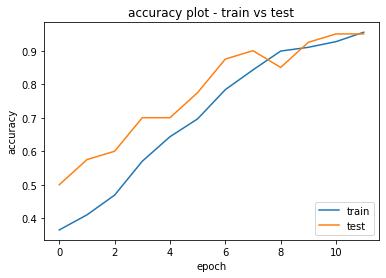

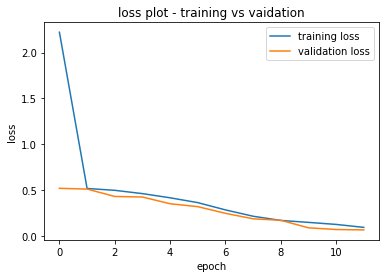

In [114]:
def plot_accuracy(y):
    if(y == True):
        plt.plot(curr_model_hist.history['accuracy'])
        plt.plot(curr_model_hist.history['val_accuracy'])
        plt.legend(['train', 'test'], loc='lower right')
        plt.title('accuracy plot - train vs test')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.show()
    else:
        pass
    return

def plot_loss(y):
    if(y == True):
        plt.plot(curr_model_hist.history['loss'])
        plt.plot(curr_model_hist.history['val_loss'])
        plt.legend(['training loss', 'validation loss'], loc = 'upper right')
        plt.title('loss plot - training vs vaidation')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.show()
    else:
        pass
    return


plot_accuracy(True)
plot_loss(True)

In [122]:
from tensorflow.keras.utils import to_categorical
from numpy import argmax

model = load_model('/content/drive/MyDrive/completed_trained_model/completemodel.h5')
y_pred = np.round( model.predict(x_test), 0)


In [123]:
from sklearn.preprocessing import OneHotEncoder

onehot_encoder = OneHotEncoder(sparse=False)
y_pred1 = y_pred
onehot_encoded = onehot_encoder.fit_transform(y_pred1)

In [124]:
onehot_encoded

array([[1., 1., 1., 1.]])

In [125]:
predicted = model.predict(X_test)
pdt = []
for i in predicted:
    if(i[0]>i[1]):
        pdt.append([1.,0.])
    else:
        pdt.append([0.,1.])
pdt = np.array(pdt)
pdt

array([[1., 0.]])

In [126]:
loaded_model = load_model('/content/drive/MyDrive/completed_trained_model/completemodel.h5')

Following code snippit can be used to test model in realtime or on custom image

ringworm


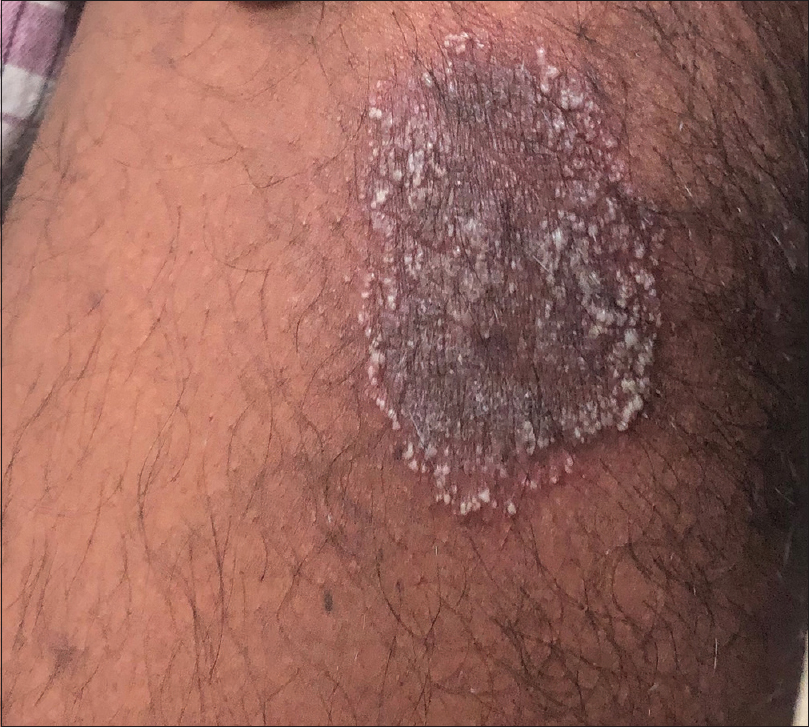

In [136]:
images = []
size = 256,256
img_file = '/content/drive/MyDrive/newlocal/ringworm/Ring001.jpg'
temp_img = cv2.imread(img_file)
temp_img = cv2.resize(temp_img, size)
images.append(temp_img)

temp_img_mean = np.mean(images)
temp_img_std = np.std(images)

x_temp_img = (images -temp_img_mean)/temp_img_std
i = loaded_model.predict(x_temp_img)

pred_lable = i.argmax()

if(pred_lable==0):
    print("Acne")
elif(pred_lable==3):
    print("Fungal")
elif(pred_lable==1):
  print("Psoriasis")
elif(pred_lable==2):
    print("ringworm")
from IPython.display import Image
Image(filename=img_file,
    width=256,
    height=256,)